### git repo work

In [6]:
from google.colab import drive
drive.mount('/content/drive')

!cp /content/drive/MyDrive/Colab/sales-forecast.ipynb /content/sales-forecast/
%cd /content/sales-forecast/


Cloning into 'sales-forecast'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 25 (delta 8), reused 15 (delta 4), pack-reused 0
Receiving objects: 100% (25/25), 29.47 MiB | 16.20 MiB/s, done.
Resolving deltas: 100% (8/8), done.
/content/sales-forecast


## actual code

In [7]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

In [8]:
file_path = '/content/sales-forecast/online_retail.xlsx'
df = pd.read_excel(file_path)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [9]:
# Check for missing values
print(df.isnull().sum())

# Basic statistics of the data
print(df.describe())

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
            Quantity                    InvoiceDate      UnitPrice  \
count  541909.000000                         541909  541909.000000   
mean        9.552250  2011-07-04 13:34:57.156386048       4.611114   
min    -80995.000000            2010-12-01 08:26:00  -11062.060000   
25%         1.000000            2011-03-28 11:34:00       1.250000   
50%         3.000000            2011-07-19 17:17:00       2.080000   
75%        10.000000            2011-10-19 11:27:00       4.130000   
max     80995.000000            2011-12-09 12:50:00   38970.000000   
std       218.081158                            NaN      96.759853   

          CustomerID  
count  406829.000000  
mean    15287.690570  
min     12346.000000  
25%     13953.000000  
50%     15152.000000  
75%     16791.000000  
max     18287.00000

In [10]:
# Replace any description containing a question mark with 'Unknown'
df['Description'] = df['Description'].apply(lambda x: 'Unknown' if '?' in str(x) else x)

#Fill any missing values with 'Unknown'
df['Description'].fillna('Unknown', inplace=True)

# Fill missing CustomerID with -1
df['CustomerID'].fillna(-1, inplace=True)

# Remove rows with negative quantities or prices
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Save the cleaned data
df.to_csv('/content/sales-forecast/cleaned_df.csv', index=False)


Monthly Sales:
   YearMonth  Quantity
0    2010-12    359239
1    2011-01    387785
2    2011-02    283555
3    2011-03    377526
4    2011-04    308815
5    2011-05    395738
6    2011-06    389213
7    2011-07    401759
8    2011-08    421770
9    2011-09    570820
10   2011-10    623401
11   2011-11    754507
12   2011-12    314248


<ipython-input-11-4c819e22947a>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(monthly_sales['YearMonth'], rotation=45, ha='right')


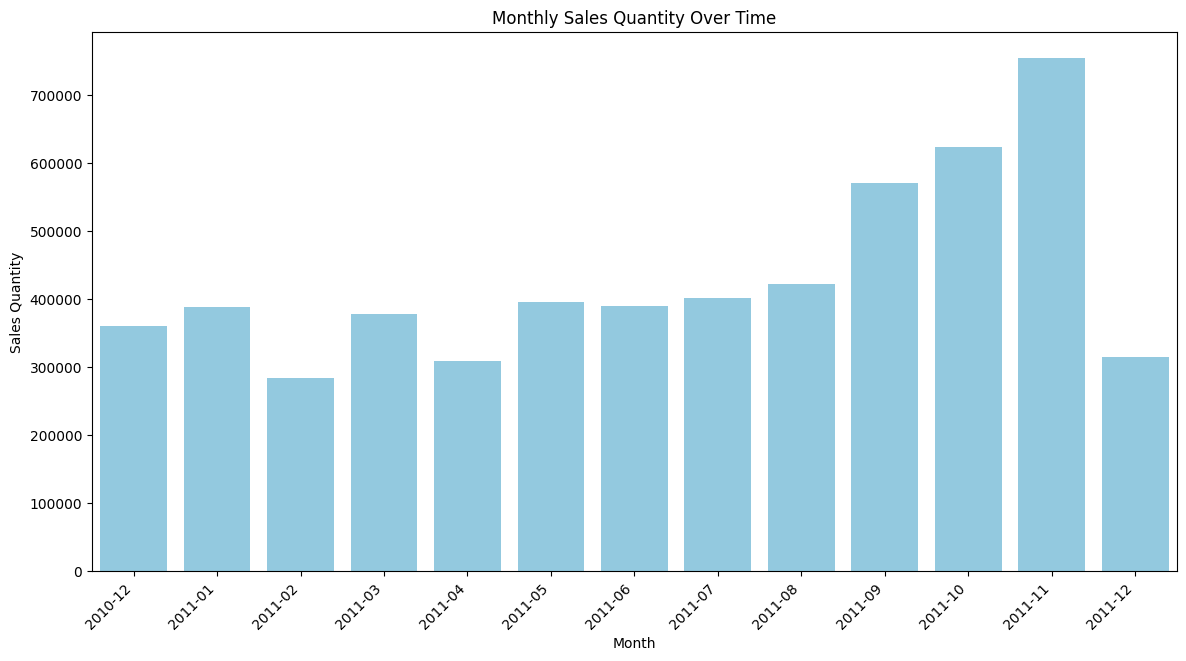

In [11]:
# Extract month and year from InvoiceDate
df['YearMonth'] = df['InvoiceDate'].dt.to_period('M')

# Group by YearMonth and sum the quantities
monthly_sales = df.groupby('YearMonth')['Quantity'].sum().reset_index()

# Convert YearMonth to datetime for plotting
monthly_sales['YearMonth'] = monthly_sales['YearMonth'].astype(str)

# Debug: Print the monthly sales to verify summation
print("Monthly Sales:")
print(monthly_sales)

# Plot the data
plt.figure(figsize=(14, 7))
sns.barplot(x='YearMonth', y='Quantity', data=monthly_sales, color='skyblue')

plt.xticks(rotation=45)
plt.gca().set_xticklabels(monthly_sales['YearMonth'], rotation=45, ha='right')

plt.title('Monthly Sales Quantity Over Time')
plt.xlabel('Month')
plt.ylabel('Sales Quantity')
plt.show()

### Feature Engineering

In [12]:
# Extract features from InvoiceDate
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['Day'] = df['InvoiceDate'].dt.day
df['WeekOfYear'] = df['InvoiceDate'].dt.isocalendar().week

# Convert to category data type (as numerical representation) for ML algorithm to process it better
df['StockCode'] = df['StockCode'].astype('category').cat.codes
df['CustomerID'] = df['CustomerID'].astype('category').cat.codes
df['Country'] = df['Country'].astype('category').cat.codes

#Create a column for revenue
df['Revenue'] = df['Quantity'] * df['UnitPrice']
# Display the first few rows to verify changes
print(df.head())


  InvoiceNo  StockCode                          Description  Quantity  \
0    536365       3539   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365       2488                  WHITE METAL LANTERN         6   
2    536365       3239       CREAM CUPID HEARTS COAT HANGER         8   
3    536365       3206  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365       3205       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID  Country YearMonth  Year  Month  \
0 2010-12-01 08:26:00       2.55        4017       36   2010-12  2010     12   
1 2010-12-01 08:26:00       3.39        4017       36   2010-12  2010     12   
2 2010-12-01 08:26:00       2.75        4017       36   2010-12  2010     12   
3 2010-12-01 08:26:00       3.39        4017       36   2010-12  2010     12   
4 2010-12-01 08:26:00       3.39        4017       36   2010-12  2010     12   

   Day  WeekOfYear  Revenue  
0    1          48    15.30  
1    1          48  

### Modeling

In [22]:
# Select features and target variable
X = df[['Quantity', 'Year', 'Month', 'CustomerID', 'StockCode', 'UnitPrice', 'Country']]
y = df['Revenue']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

### Evaluation

In [23]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')

Mean Squared Error: 16605.48
R-squared: 0.14


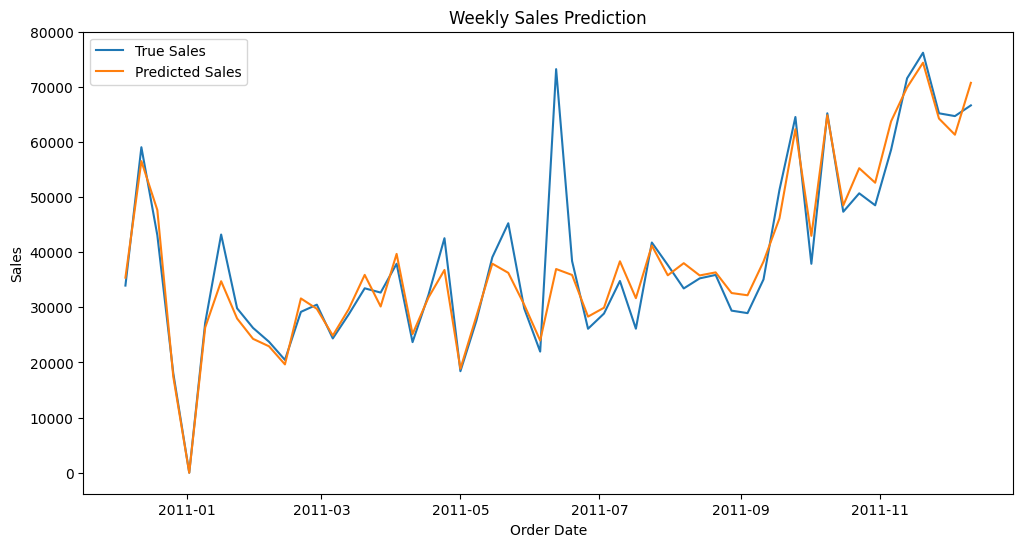

In [27]:
# Create a copy of the test set and add the 'InvoiceDate', 'true_sales', and 'predicted_sales' columns
test_df = X_test.copy()
test_df['InvoiceDate'] = df.loc[X_test.index, 'InvoiceDate']  # Retrieve the corresponding InvoiceDate for each row in the test set
test_df['true_sales'] = y_test  # Add the true sales values to the test set
test_df['predicted_sales'] = y_pred  # Add the predicted sales values to the test set

# Convert 'InvoiceDate' to datetime format
test_df['InvoiceDate'] = pd.to_datetime(test_df['InvoiceDate'])

# Set 'InvoiceDate' as the index
test_df.set_index('InvoiceDate', inplace=True)

# Resample the data to a weekly frequency and sum the sales
test_df_resampled = test_df.resample('W').sum()

# Create a line plot of sales predictions as a function of InvoiceDate
plt.figure(figsize=(12, 6))

# Plot the true sales values against the InvoiceDate
sns.lineplot(data=test_df_resampled, x='InvoiceDate', y='true_sales', label='True Sales')

# Plot the predicted sales values against the InvoiceDate
sns.lineplot(data=test_df_resampled, x='InvoiceDate', y='predicted_sales', label='Predicted Sales')

# Set the x-axis label
plt.xlabel('Order Date')
plt.ylabel('Sales')
plt.title('Weekly Sales Prediction')
plt.legend()
plt.show()
